## EDA detección de spam

### Importar librerías

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

### Carga del dataset

In [13]:
df = pd.read_csv(
    "data/data_spam.csv",
    sep=",",
    usecols=[0, 1],                 # solo columnas reales
    names=["label", "text"],        # renombrar columnas
    encoding="latin1",              # codificación correcta para Windows
    engine="python",                # mejor manejo de comillas y comas internas
    on_bad_lines="skip"             # saltar filas mal formadas
)
df = df.iloc[1:].reset_index(drop=True)
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Dimensiones del dataset

In [14]:
df.shape

(5572, 2)

Las dimensiones del dataset son 5572 registros por dos columnas llamadas label y text.

### Información general

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


En el conjunto de datos no existen valores nulos.

### Distribución de clases (Spam vs No Spam)

In [18]:
df['label'].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

Podemos observar que el dataset no se encuentra balanceado. Los correos marcados como spam son mucho menores que los correos marcados como no spam.

### Porcentaje por clase

In [21]:
porc = df['label'].value_counts(normalize=True).mul(100).round(2)

pd.DataFrame({
    'Clase': porc.index,
    'Porcentaje (%)': porc.values
})



,Clase,Porcentaje (%)
0,ham,86.59
1,spam,13.41


Esta diferencia se puede representar en términos porcentuales como se ve en la tabla anterior. En ella, se puede apreciar que los correos no spam representan el 86,59% del total, mientras que aquellos reportados como spam repsentan solo el 13,41% del total.

### Longitud del texto

In [22]:

df['text_length'] = df['text'].astype(str).apply(len)
df[['text_length']].describe()


,text_length
count,5572.000000
mean,80.118808
std,59.690841
min,2.000000
25%,36.000000
50%,61.000000
75%,121.000000
max,910.000000


### Distribución de la longitud del texto

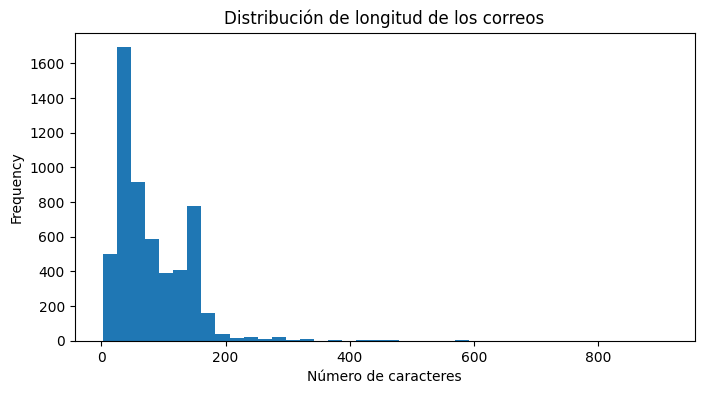

In [23]:

df['text_length'].plot(kind='hist', bins=40, figsize=(8,4))
plt.title("Distribución de longitud de los correos")
plt.xlabel("Número de caracteres")
plt.show()


A partir del gráfico anterior, podemos afirmar que existen algunos mensajes que exceden los 200 caracteres. Esto quiere decir que el dataset contiene mensajes atipicamente largos pero no son demasiados. Por otra parte, la mayor cantidad de mensajes está en un rango de caracteres diferente de cero a un poco menos de 200 caracteres.

### Longitud del texto por clase

In [24]:
df.groupby('label')['text_length'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,4825.0,71.023627,58.016023,2.0,33.0,52.0,92.0,910.0
spam,747.0,138.866131,29.183082,13.0,132.5,149.0,157.0,224.0


Limpieza

In [26]:
import re

def limpiar(texto):
    texto = texto.lower()
    texto = re.sub(r"[^a-zA-Záéíóúñ ]", " ", texto)
    return texto


Clases

In [27]:
spam = df[df['label'] == "spam"]['text'].astype(str).apply(limpiar)
ham  = df[df['label'] == "ham"]['text'].astype(str).apply(limpiar)


### Nube de palabras

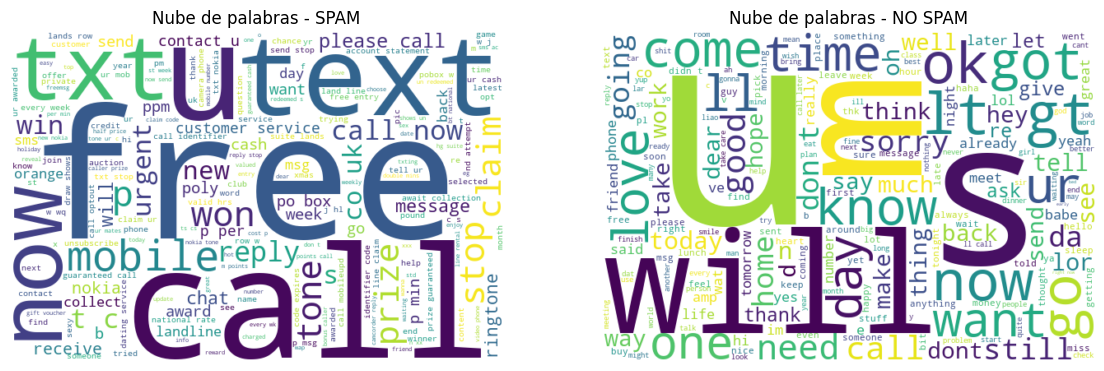

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

spam_text = " ".join(spam)
ham_text = " ".join(ham)

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
wc_spam = WordCloud(width=600, height=400, background_color="white").generate(spam_text)
plt.imshow(wc_spam, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras - SPAM")

plt.subplot(1,2,2)
wc_ham = WordCloud(width=600, height=400, background_color="white").generate(ham_text)
plt.imshow(wc_ham, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras - NO SPAM")

plt.show()


El gráfico "nube de palabras" nos permite visualizar las palabras más frecuentes en el dataset separado por clase "spam" y "ham". Este gráfico nos permite identificar que es necesario hacer manejo de palabras comodín y además agregar contexto suficiente para que palabras muy frecuentes como "will" tengan sentido semántico.

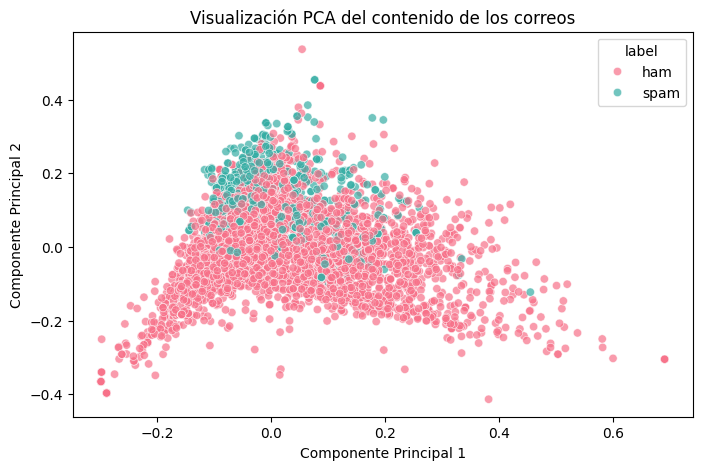

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

tfidf = TfidfVectorizer(max_features=500)
X = tfidf.fit_transform(df['text'].astype(str)).toarray()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['label'], palette="husl", alpha=0.7)
plt.title("Visualización PCA del contenido de los correos")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()


El gráfico de Principal Component Analysis (PCA) anterior nos permite visualmente evidenciar por qué la clasificación de lenguaje natural puede resultar tan complicada. De acuerdo al análisis, no existe una clara difenrencia, mucho menos lineal, entre correos spam y correos no spam. Esto se puede deber a varios factores. En primer lugar, la complejidad misma del lenguaje natural. En segundo lugar, la falta de datos de correos reportados como "spam" no crea un clúster claro. Sin embargo, es apreciable un pequeño agrupamiento hacia valores altos del componente dos. Esto podría explotarse en el modelo de clasificación para lograr mejores resultados. Cabe aclarar que el propósito de PCA no es hacer una clasificación en sí misma sino que resume la estructura de los datos.